# Naive Bayes - solution on Iris dataset

In [1]:
%pylab inline
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

import pandas as pd

iris = datasets.load_iris()

Populating the interactive namespace from numpy and matplotlib


## Scikit-Learn Implementation
The code below presents the whole solution with a single line of code, as per **Scikit-Learn** [documentation](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes).

Number of mislabeled points out of a total 150 points : 6


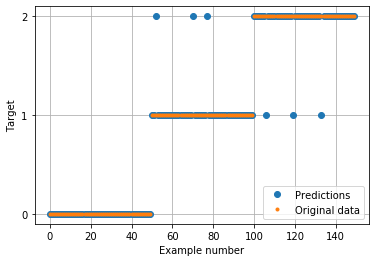

In [2]:
gnb = GaussianNB()
y_pred = gnb.fit(iris.data, iris.target).predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d"
      % (iris.data.shape[0],(iris.target != y_pred).sum()))

fig, ax = plt.subplots()
ax.plot(y_pred, 'o')
ax.plot(iris.target, '.')
ax.set_ylabel('Target')
ax.set_xlabel('Example number')
ax.set_yticks([0, 1, 2])
ax.legend(['Predictions', 'Original data'], loc='lower right')
ax.grid()
plt.show()

Comparing the predictions with the actual labels, we can easily spot the misclassified examples (six in total).

## Dataset Analysis
Before we dive into implementation of the Naive Bayes algorithm ourselves, let's first illustrate how the data looks. Most importantly, we will look into _distributions_ and probabilities associated with features and labels in the dataset.

In [3]:
data = pd.DataFrame(iris.data, columns=iris.feature_names)
target = pd.DataFrame(iris.target, columns=['value'])
target['label'] = target.apply(lambda x: iris['target_names'][x])

In [4]:
data.sample(n=3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
43,5.0,3.5,1.6,0.6
7,5.0,3.4,1.5,0.2
74,6.4,2.9,4.3,1.3


In [5]:
target.sample(n=3)

,value,label
109,2,virginica
79,1,versicolor
144,2,virginica


In [6]:
print ("Target labels: ", iris.target_names)
print ("Target values: ", np.unique(iris.target))
print ("Features: ", iris.feature_names)
print ("Number of examples: ", len(data))

Target labels:  ['setosa' 'versicolor' 'virginica']
Target values:  [0 1 2]
Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Number of examples:  150


Here, we have encapsulated the dataset into _pandas dataframe_ objects, for easier manipulation. Most importatnly, we know that the dataset has 4 features, 3 labels (categories, enumerated as 0, 1 and 2) and 150 examples in total.

Let's confrim that the distributon of the _likelihood_ functions is indeed _Gaussian_.
Note that even if it was not, the Bayes formula **still holds**.
We would however need to seek to define the distributions ourselves, and we would not be able to use the `GaussianNB` class available in the library.

If the data is indeed distributed accoring the the Gaussian function, we should be able to see the correspondence between the _histograms_ of the data and the function itself.

Let's recall the Gaussian function and implement it in the code:

$$G(x; \theta, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{(x - \theta)^2}{2 \sigma^2} \right)$$

where $\theta$ is the mean and $\sigma^2$ is variance.

In [7]:
def gaussian(x, theta, sigma, A=1.0):
    return A/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x - theta)**2 / (sigma**2))

step = 0.001
assert abs(np.sum(gaussian(np.arange(-100.0, 100.0, step=step), 1.0, 2.0))*step - 1) < 1e-6

In the example above we basically assert that $\int_{-\infty}^\infty G(x) \text{d}x = 1$, taking rather distant limits and small $\text{d}x$.

Now, let's check if the _likelihood_ functions $p(x_i|y_j)$ can be approximated with Gaussian function.

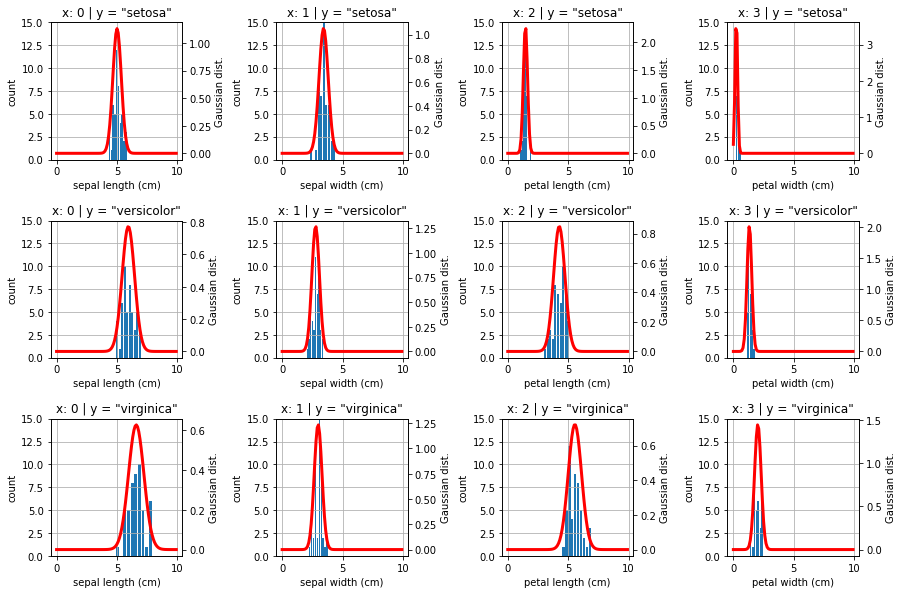

In [8]:
fig, axs = plt.subplots(3, 4, figsize=(12, 8))
fig.tight_layout(h_pad=4, w_pad=6)

for y, label in zip(range(len(iris['target_names'])), iris['target_names']):
    for x, feature in zip(range(len(iris['feature_names'])), iris['feature_names']):
        variable = data[target['label'] == label][feature]
        axs[y, x].hist(variable, rwidth=0.8)
        ax2 = axs[y, x].twinx()
        line = np.arange(0.0, 10.0, step=0.1)
        ax2.plot(line, gaussian(line, variable.mean(), variable.std()), 'red', lw=3)
        axs[y, x].grid()
        axs[y, x].set_title('x: {} | y = "{}"'.format(x, label))
        axs[y, x].set_ylim([0, 15])
        axs[y, x].set_ylabel('count')
        axs[y, x].set_xlabel(feature)
        ax2.set_ylabel('Gaussian dist.')
plt.show()

Apparently they do.

Note that we use `variable = data[target['label'] == label][feature]` command to first select all entries from the `data` that do belong to a specific category, which mathematically corresponds to $...|y_j$ (on condition that $y_j$),
and then we select `[feature]` to be our `variable` thus making $(x_i|y_j)$ part.

Having plotted the histogram, we can then identify our mean `\theta` and variance `sigma^2` to adjust the position and shape of the Gaussian function and see it it fits at all.

Consequently, for every feature `x_i` and every target `y_j`, all we need to construct a likelihood function is $\theta$ and $\sigma$.

In fact, that's exactly what `GaussianNB` class does.

In [9]:
print ("Means:")
print (gnb.theta_)
print ("")
print ("Variances:")
print (gnb.sigma_)

Means:
[[5.006 3.428 1.462 0.246]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]

Variances:
[[0.121764 0.140816 0.029556 0.010884]
 [0.261104 0.0965   0.2164   0.038324]
 [0.396256 0.101924 0.298496 0.073924]]


## Manual implementation
According to the Bayes theorem, we only need three elemements:
* The likelihood functions $p(x|y)$, and we know they are Gaussian in this example.
* The _prior_ probabilities $p(y)$, we can easily find.
* The _evidence_ probabilities $p(x)$.

In fact, $p(x)$ are not that needed if our intention is only to find the most likely label given a set of features.
Unless we insist that our output number has a probabilistic interpretation, all we need is the first two, so we can reason from the following proprtion:

$$p(y|x) \propto p(x|y)p(y)$$

### Constructing _priors_ 

In [10]:
prob_y = target.groupby(by='value').count()/len(target)
print (prob_y)

          label
value          
0      0.333333
1      0.333333
2      0.333333


That's it.
Counting the number of particular labels in the dataset and dividing it by the total number of labels defines the _unconditional_ probability of picking $y_j$ form the dataset (without looking at the features). In our case, they are all equal.

### Constructing _likelihoods_
There are many ways to implement the likelihood functions. Here, we will make a few tricks with _pandas_.
It will make our approach more "verbose" and _vectorized_ at the same time. (No explicit loops!)

First, let's define our data frame of means `THETA`.
It is a 4 by 3 array with descriptions.

In [11]:
THETA = pd.DataFrame([data[target['value'] == x].mean() for x in target['value'].unique()])
print (THETA)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0              5.006             3.428              1.462             0.246
1              5.936             2.770              4.260             1.326
2              6.588             2.974              5.552             2.026


Similarly, we can define a similar data frame of variances `SIGMA`.

In [12]:
SIGMA = pd.DataFrame([data[target['value'] == x].std() for x in target['value'].unique()])**2
print (SIGMA)

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           0.124249          0.143690           0.030159          0.011106
1           0.266433          0.098469           0.220816          0.039106
2           0.404343          0.104004           0.304588          0.075433


Now our challange is to "merge" the two dataframes in a way that element-wise produces output from a Gaussian function and does that for an array of new features.

For that purpose we will define an auxiliary dataframe, which for every feature-label element would contain an array of three numbers: input feature $x_i$, $\theta$ for $p(x_i|y_j)$ and $\sigma$ for $p(x_i|y_j)$.
This will allow us to use `.applymap` method later, to compute $G(x; \theta, \sigma^2)$ for every element in this array.

In [13]:
X = np.array([5, 1, 2, 4])
Z = pd.DataFrame(np.rec.fromarrays((np.tile(X, (3, 1)), THETA.values, SIGMA.values)).tolist())
Z = Z.applymap(lambda x: gaussian(x[0], x[1], x[2]))
Z

,0,1,2,3
0,3.207088,2.768999e-62,1.050091e-68,0.000000e+00
1,0.003129,2.793755e-70,3.241007e-23,0.000000e+00
2,0.000441,2.282707e-78,3.858231e-30,1.039649e-148


The above table presents a product of the computation of $G(x; \theta, \sigma^2)$, essentially being our $p(x_i|y_j)$ for $i = \{0, 1, 2, 3\}$ and $j = \{0, 1, 2\}$.

That was the most difficult part of our model.

Next, we need to multiply the likelohoods of our features, as **Naive** Bayes recipe tells us to 

$$p(x|y_j) = \prod_i p(x_i|y_j)$$

(remember: the features are assumed to be independent).



In [14]:
Z.prod(axis=1)

0     0.000000e+00
1     0.000000e+00
2    4.041776e-259
dtype: float64

To get the output, we should multiply the above result with our priors $p(x|y_j)p(y_j)$. Evebn though those priors are all equal, let's be formal.

In [15]:
(Z.prod(axis=1).to_numpy())*(prob_y.to_numpy())[0, :]

array([0.0000000e+000, 0.0000000e+000, 1.3472586e-259])

Our solution is the **index** of the value that is the highest within the array.

In [16]:
y_pred2 = np.argmax((Z.prod(axis=1).to_numpy())*(prob_y.to_numpy())[0, :])
print (y_pred2)

2


### The Model
Let's now collect the lines and make them one function, that would accept an array of _feature values_ and output the candidate for a _label_.

In [17]:
def predict(X):
    X = np.array(X)
    Z = pd.DataFrame(np.rec.fromarrays((np.tile(X, (3, 1)), THETA.values, SIGMA.values**0.5)).tolist())
    Z = Z.applymap(lambda x: gaussian(x[0], x[1], x[2]))
    Z = (Z.prod(axis=1).to_numpy())*(prob_y.to_numpy())[0, :]
    return np.argmax(Z)

If our function is correct, it should render the same candidates as the original `GaussianNB` class, including the mistakes.
To verify this, we can apply the `predict` function to the whole array of `data`, which are our original features.

In [18]:
y_pred2 = data.apply(lambda x: predict(x), axis=1).to_numpy()

if (y_pred == y_pred2).sum() == len(data):
    print ("Yes! We have the same result.")
else:
    print ("@#$& it!")

Yes! We have the same result.


## Conclusion
In this notebook we have shown the principle behind Naive Bayes classifier. Using the scikit-learn implementation as reference and a popular Iris dataset, we have demonstrated how the theorem can be manually implemented, taking advantage of the Gaussian distribution of features.

Important take-aways from this example:
* The Naive Bayes approach works only if the features are independent.
* The Naive Bayes algorithm does not require that the data is Gaussian distributed.
* If it is , however, the Gaussian distribution is characterized with two numbers: mean and variance only.
* Either way, all we need to do is to find likelihoods and priors.
